# Variational Auto-Encoders

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.distributions.normal import Normal

sns.set_style("whitegrid")

In [2]:
class InferenceNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        
        self.input2hidden = nn.Linear(self.input_size, self.hidden_size)
        self.hidden2mu = nn.Linear(self.hidden_size, self.latent_size)
        self.hidden2logvar = nn.Linear(self.hidden_size, self.latent_size)
        
    def forward(self, x):
        h = torch.tanh(self.input2hidden(x))
        mu = self.hidden2mu(h)
        logvar = self.hidden2logvar(h)
        return mu, logvar

In [3]:
class RecognitionNetwork(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size):
        super().__init__()
        
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.latent2hidden = nn.Linear(self.latent_size, self.hidden_size)
        self.hidden2output = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, z):
        h = torch.tanh(self.latent2hidden(z))
        x_prime = torch.sigmoid(self.hidden2output(h))
        return x_prime

In [4]:
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        
        self.encoder = InferenceNetwork(self.input_size, self.hidden_size, self.latent_size)
        self.decoder = RecognitionNetwork(self.latent_size, self.hidden_size, self.input_size)
        
    def reparametrize(self, mu, logvar):
        eps = torch.randn_like(logvar)
        return mu + (eps * torch.exp(logvar))
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        x_tilde = self.decoder(z)
        return mu, logvar, x_tilde

In [5]:
class Binarize():
    def __init__(self, threshold=0.5):
        self.threshold = threshold
    def __call__(self, tensor):
        return (tensor > self.threshold).type(tensor.type())
    
transform = transforms.Compose([transforms.ToTensor(), Binarize()])
train_dataset = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST("./data", train=False, download=True, transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [6]:
def KL_divergence(mu, logvar):
    return -0.5 * torch.sum(logvar + 1. - torch.exp(logvar) - mu**2)

x_entropy = nn.BCELoss(reduction="sum")

## Training the Network

In [7]:
input_size = 28*28
hidden_size = 400
latent_size = 2
learning_rate = 1e-3
batch_size = 128
num_epochs = 20

model = VAE(input_size, hidden_size, latent_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
kl_train = list()
recon_train = list()
kl_test = list()
recon_test = list()

for epoch in range(1, num_epochs+1):
    epoch_kl = 0
    epoch_recon = 0
    if epoch % 5 == 0:
        print(f"Training epoch {epoch}")
    
    # training
    for (x, _) in train_loader:
        optimizer.zero_grad()
        x = x.view(-1, input_size).float()
        mu, logvar, x_tilde = model(x)
        kl_div = KL_divergence(mu, logvar)
        recon_loss = x_entropy(x_tilde, x)
        epoch_kl += kl_div.item()
        epoch_recon += recon_loss.item()
        loss = kl_div + recon_loss
        loss.backward()
        optimizer.step()
    kl_train.append(epoch_kl / len(train_dataset))
    recon_train.append(epoch_recon / len(train_dataset))
    
    # testing
    with torch.no_grad():
        epoch_kl = 0
        epoch_recon = 0
        for (x, _) in test_loader:
            x = x.view(-1, input_size).float()
            mu, logvar, x_tilde = model(x)
            kl_div = KL_divergence(mu, logvar)
            recon_loss = x_entropy(x_tilde, x)
            epoch_kl += kl_div.item()
            epoch_recon += recon_loss.item()
        kl_test.append(epoch_kl / len(test_dataset))
        recon_test.append(epoch_recon / len(test_dataset))
    
kl_train = np.array(kl_train)
recon_train = np.array(recon_train)
kl_test = np.array(kl_test)
recon_test = np.array(recon_test)


Training epoch 5
Training epoch 10
Training epoch 15
Training epoch 20


## Plotting the Training and Test Results

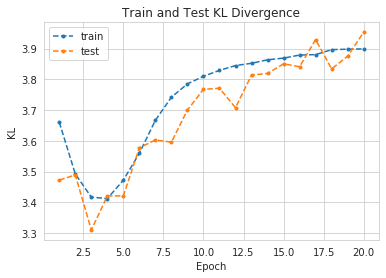

In [27]:
epochs_idx = [i for i in range(1, num_epochs+1)]
fig, ax = plt.subplots()

# plotting KL divergences
ax.plot(epochs_idx, kl_train, linestyle="--", marker=".", label="train")
ax.plot(epochs_idx, kl_test, linestyle="--", marker=".", label="test")
ax.set_xlabel("Epoch")
ax.set_ylabel("KL")
ax.set_title("Train and Test KL Divergence")
ax.legend()

fig.savefig("vanilla_vae_kl.png")
plt.show()

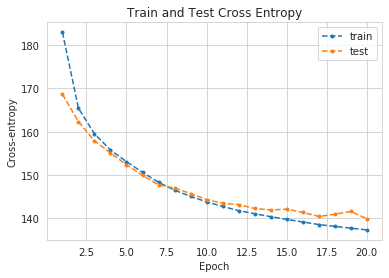

In [26]:
fig, ax = plt.subplots()

# plotting reconstruction losses
ax.plot(epochs_idx, recon_train, linestyle="--", marker=".", label="train")
ax.plot(epochs_idx, recon_test, linestyle="--", marker=".", label="test")
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross-entropy")
ax.set_title("Train and Test Cross Entropy")
ax.legend()

fig.savefig("vanilla_vae_xentropy.png")
plt.show()

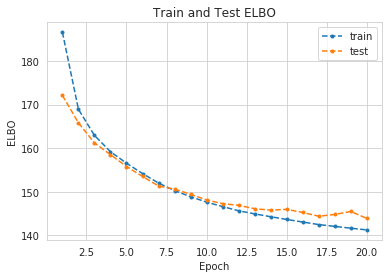

In [25]:
fig, ax = plt.subplots()

# plotting ELBOs
ax.plot(epochs_idx, kl_train + recon_train, linestyle="--", marker=".", label="train")
ax.plot(epochs_idx, kl_test + recon_test, linestyle="--", marker=".", label="test")
ax.set_xlabel("Epoch")
ax.set_ylabel("ELBO")
ax.set_title("Train and Test ELBO")
ax.legend()

fig.savefig("vanilla_vae_elbo.png")
plt.show()

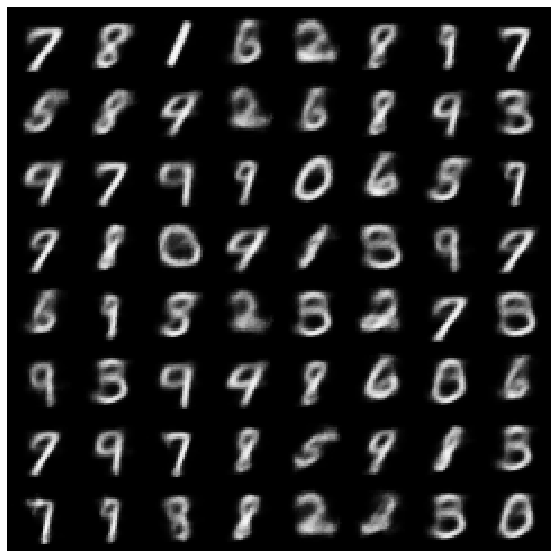

In [78]:
num_samples = 64
with torch.no_grad():
    z = torch.randn(num_samples, latent_size)
    x_tilde = model.decoder(z).view(num_samples, 1, 28, 28)
    save_image(x_tilde, "vanilla_vae_samples.png")
    
img = mpimg.imread('./vanilla_vae_samples.png')
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
ax.grid(False)
plt.axis("off")
plt.show()